# Perform Network Analysis
* Create a covariance matrix
* Find an ideal noise-removing threshold filter with Random Matrix Theory
* Analyze properties of the network

## TODO: Split Dataset into Sample Groups

## Network Construction
* create a pair-wise similarity (Pearson) of abundance across different samples
* determine adjacency matrix by RMT-based approach

In [8]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [9]:
from numpy import linalg as LA

In [10]:
import empyricalRMT as rmt
from empyricalRMT.construct import generate_eigs
from empyricalRMT.eigenvalues import Eigenvalues

## Import Data

In [11]:
# load data
df_counts_rel = pd.read_csv("data/FCF_relative_counts.csv", index_col=0)
df_annotations = pd.read_csv("data/FCF_annotations_corrected.csv", index_col=0)

print("df_counts_rel.shape", df_counts_rel.shape)
print("df_annotations.shape", df_annotations.shape)

df_counts_rel.shape (87, 60)
df_annotations.shape (87, 4)


## Create A Covariance Matrix

In [12]:
# make pearson correlation matrix
df_counts_rel_corr = df_counts_rel.corr(method="pearson")

# make similarity data
S_corr = df_counts_rel_corr.abs()

# set an initial threshold value
s_tb = 0.05

## Use Random Matrix Theory

Good overview of Random Matrix Theory by [Torsten Scholak](https://tscholak.github.io/code/physics/2015/05/05/unfoldr.html)

TODO: figure out if my Poisson distribution is very off... my chi_squared value seems unreal...

In [13]:
def get_thresholded_matrix(S_corr, s_t, verbose=False):
    # apply threshold
    A = S_corr >= s_t
    A = A.astype(int)
    # replace values on diagonals with 0
    np.fill_diagonal(A.values, 0)
    # keep non-zero rows and columns
    A = A.loc[:, (A != 0).any(axis=0)]
    A = A.loc[(A != 0).any(axis=1), :]
    if verbose:
        # get a sense of how many OTUs remain
        print("A.shape", A.shape)
    return A


def get_unfolded_eigs(S_corr, s_t, verbose=False):
    A = get_thresholded_matrix(S_corr, s_t)
    
    # calculate eigenvalues
    w, _ = LA.eig(A)
    # sort eigenvalues
    # To test NNSD distribution, order the eigenvalue, smallest first
    w_sorted = np.sort(w)

    # use empiricalRMT library
    eigs = Eigenvalues(w_sorted)

    # unfold the eigenvalues by fitting to cubic spline
    unfolded = eigs.unfold(smoother="poly", degree=3)

    if verbose:
        # plot some classic observables and compare to theory
        ensembles = ["poisson", "goe"]  # theoretically expected curves to plot
        unfolded.plot_nnsd(ensembles=ensembles)  # nearest neighbours spacings

    return unfolded.vals


def get_expected_poisson(unfolded):
    p = np.pi
    _spacings = np.diff(unfolded)
    s = np.linspace(_spacings.min(), _spacings.max(), len(unfolded))
    poisson = np.exp(-s)
    return poisson


def get_expected_GOE(unfolded):
    p = np.pi
    _spacings = np.diff(unfolded)
    s = np.linspace(_spacings.min(), _spacings.max(), len(unfolded))
    goe = ((p * s) / 2) * np.exp(-(p / 4) * s * s)
    return goe


def chi_squared(observed, expected):
    d = (observed-expected)**2
    d = d/expected
    d = d.sum()
    return d


def find_threshold(S_corr, s_tb, alpha=0.05):
    """
    Use Random Matrix Theory to find a threshold to 
    separate random noise (following GOE NNSD) 
    from non-random signal (following Poisson NNSD).
    
    H0: P(d) follows the Poisson distribution
    H1: P(d) does not follow the Poisson distribution
    """
    
    # set significance threshold
    s_t = s_tb
    
    coarse_step = 0.1
    fine_step = 0.01
    is_finding_finer_theshold = False    
    
    s_t_vals = []
    unfolded_len_vals = []
    Xsq_crit_vals = []
    Xsq_poisson_vals = []
    Xsq_GOE_vals = []
    
    while(s_t < 1.0):
        unfolded = get_unfolded_eigs(S_corr, s_t, verbose=False)
        Xsq_crit = scipy.stats.chi2.ppf(1-alpha, df=len(unfolded)-1)
        
        # chi-square for poisson distribution
        expected_poisson = get_expected_poisson(unfolded)
        Xsq_poisson = chi_squared(unfolded, expected_poisson)
        
        # chi-square for gaussian distribution
        expected_GOE = get_expected_GOE(unfolded)
        Xsq_GOE = chi_squared(unfolded, expected_GOE)
        
        # savepoint
        s_t_vals.append(s_t)
        unfolded_len_vals.append(len(unfolded))
        Xsq_crit_vals.append(Xsq_crit)
        Xsq_poisson_vals.append(Xsq_poisson)
        Xsq_GOE_vals.append(Xsq_GOE)
        
        # savepoint
        print("s_t", s_t)
        print("len(unfolded)", len(unfolded))
        print("Xsq_crit", Xsq_crit)
        print("Xsq_poisson", Xsq_poisson)
        print("Xsq_GOE", Xsq_GOE)
        
        if (is_finding_finer_theshold):
            if (Xsq_poisson > Xsq_crit):
                print("--accept Poisson")
                # reject null hypothesis that NNSD is Poisson
                s_t += fine_step
            
            else:
                # do not reject null hypothesis that NNSD is Poisson
                break
    
        else:
            if (Xsq_poisson > Xsq_crit):
                # reject null hypothesis that NNSD is Poisson
                print("--reject Poisson")
                s_t += coarse_step

            else:
                # do not reject null hypothesis that NNSD is Poisson
                # find a finer threshold
                s_t -= coarse_step
                is_finding_finer_theshold = True
    
    print("s_t_vals", s_t_vals)
    print("unfolded_len_vals", unfolded_len_vals)
    print("Xsq_crit_vals", Xsq_crit_vals)
    print("Xsq_poisson_vals", Xsq_poisson_vals)
    print("Xsq_GOE_vals", Xsq_GOE_vals)
            
    return s_t        

In [14]:
find_threshold(S_corr, 0.3, alpha=0.5)

s_t 0.3
len(unfolded) 60
Xsq_crit 58.33468914643707
Xsq_poisson 7770300.954883633
Xsq_GOE inf
--reject Poisson
s_t 0.4
len(unfolded) 60
Xsq_crit 58.33468914643707
Xsq_poisson 5188369.444913099
Xsq_GOE inf
--reject Poisson
s_t 0.5
len(unfolded) 59
Xsq_crit 57.334712814818765
Xsq_poisson 7113043.838085005
Xsq_GOE inf
--reject Poisson
s_t 0.6
len(unfolded) 53
Xsq_crit 51.334874205924834
Xsq_poisson (11472979.837415377-8.696346172319038e-11j)
Xsq_GOE (inf-infj)
--reject Poisson
s_t 0.7
len(unfolded) 41
Xsq_crit 39.33534484661134
Xsq_poisson 2925742.812956208
Xsq_GOE inf
--reject Poisson
s_t 0.7999999999999999
len(unfolded) 32
Xsq_crit 30.33594245819813
Xsq_poisson 1584963.4244634905
Xsq_GOE inf
--reject Poisson
s_t 0.8999999999999999
len(unfolded) 15
Xsq_crit 13.33927414909954
Xsq_poisson 194079.37872329363
Xsq_GOE inf
--reject Poisson


<ipython-input-13-a853e8cc8e28>:57: RuntimeWarning: divide by zero encountered in true_divide
  d = d/expected
<ipython-input-13-a853e8cc8e28>:57: RuntimeWarning: divide by zero encountered in true_divide
  d = d/expected
<ipython-input-13-a853e8cc8e28>:57: RuntimeWarning: divide by zero encountered in true_divide
  d = d/expected
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/empyricalRMT/_validate.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(array, dtype=float)
<ipython-input-13-a853e8cc8e28>:57: RuntimeWarning: divide by zero encountered in true_divide
  d = d/expected
<ipython-input-13-a853e8cc8e28>:57: RuntimeWarning: divide by zero encountered in true_divide
  d = d/expected
<ipython-input-13-a853e8cc8e28>:57: RuntimeWarning: divide by zero encountered in true_divide
  d = d/expected
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1336: RankWarning: The fit may be poor

TypeError: expected non-empty vector for x

## Data Is Too Messy
Since the data is too messy, this code lets you eyeball the threshold where the data fits the Poisson distribution more than it fits the GOE distribution.

/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/empyricalRMT/_validate.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(array, dtype=float)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=or

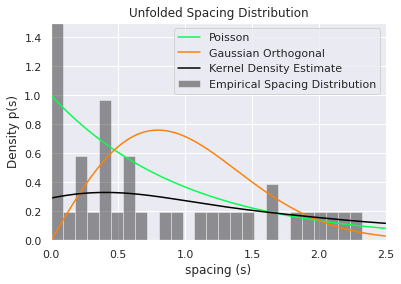

Xsq_poisson (15041810.811162408-5.496957590161601e-11j)
Xsq_crit 77.93052380523042


/home/gaher/miniconda3/envs/MBEnv/lib/python3.8/site-packages/numpy/lib/histograms.py:854: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)


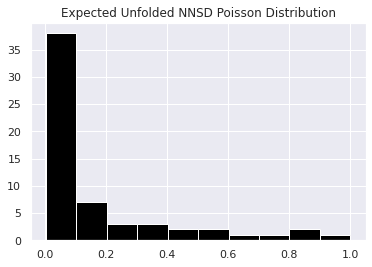

In [15]:
def visualize_threshold(S_corr, theshold):
    unfolded = get_unfolded_eigs(S_corr, theshold, verbose=True)

    Xsq_crit = scipy.stats.chi2.ppf(1-0.05, df=len(unfolded)-1)

    # chi-square for poisson distribution
    expected_poisson = get_expected_poisson(unfolded)
    Xsq_poisson = chi_squared(unfolded, expected_poisson)

    print("Xsq_poisson", Xsq_poisson)
    print("Xsq_crit", Xsq_crit)

    plt.figure()
    plt.hist(get_expected_poisson(unfolded))
    plt.title("Expected Unfolded NNSD Poisson Distribution")
    
visualize_threshold(S_corr, 0.47)

## Analyze Network Properties:

**Key Characteristics:**
* k-core, average path length, local clustering coefficient
* the average degree, degree distribution
* module, clique, motif

**Features of Nodes:**
* degree, degree centrality
* node-betweenness, node-betweenness centrality
* closeness, cluster coefficient, coreness
* eigenvector centrality

**Special Nodes:**
* modular hub node
* connector node
* peripheral node

**Features of Edges:**
* shortest path, distance
* edge-betweenness

---

Sources:
* https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

In [16]:
import networkx as nx
from networkx.algorithms import community # This part of networkx, for community detection, needs to be imported separately.
from operator import itemgetter

In [17]:
s_t = 0.47
A = get_thresholded_matrix(S_corr, s_t)
A.shape
type(A)

pandas.core.frame.DataFrame

In [18]:
G = nx.from_numpy_array(A.to_numpy())

otu_dict = {}
for node in G.nodes:
    otu_dict[node] = A.index[node]
G=nx.relabel_nodes(G,otu_dict)

# nx.set_node_attributes(G, otu_dict, "OTU")

In [19]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 60
Number of edges: 175
Average degree:   5.8333


## Degree Plot (Useful? Probably Not)

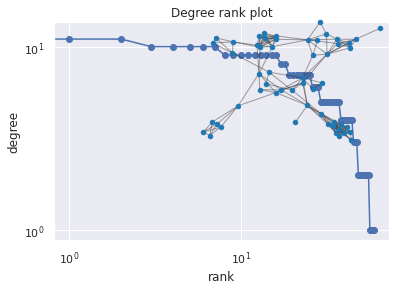

In [20]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
dmax = max(degree_sequence)

plt.loglog(degree_sequence, "b-", marker="o")
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

# draw graph in inset
plt.axes([0.45, 0.45, 0.45, 0.45])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc)
plt.axis("off")
nx.draw_networkx_nodes(Gcc, pos, node_size=20)
nx.draw_networkx_edges(Gcc, pos, alpha=0.4)
plt.show()

### Key Characteristics

**Density:** tells you how connected a network is. A 0 density would mean that there are no connections at all, and a 1 would indicate that all possible edges are present (a perfectly connected network).

In [21]:
density = nx.density(G)
print("Network density:", density)

Network density: 0.09887005649717515


**Transitivity:** like density, expresses how interconnected a graph is in terms of a ratio of actual over possible connections. A triangle is formed if two nodes that are connected to a node are also connected to each other.

In [22]:
triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

Triadic closure: 0.7005347593582888


There are many network metrics derived from shortest path lengths. One such measure is **diameter**, which is the longest of all shortest paths. After calculating all shortest paths between every possible pair of nodes in the network, diameter is the length of the path between the two nodes that are furthest apart. The measure is designed to give you a sense of the network’s overall size, the distance from one end of the network to another.

In [23]:
# If your Graph has more than one component, this will return False:
print(nx.is_connected(G))

# Next, use nx.connected_components to get the list of components,
# then use the max() command to find the largest one:
components = nx.connected_components(G)
largest_component = max(components, key=len)

# Create a "subgraph" of just the largest component
# Then calculate the diameter of the subgraph, just like you did with density.

subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print("Network diameter of largest component:", diameter)

False
Network diameter of largest component: 7


## Visualize Network

Text(0.5, 1.0, 'network')

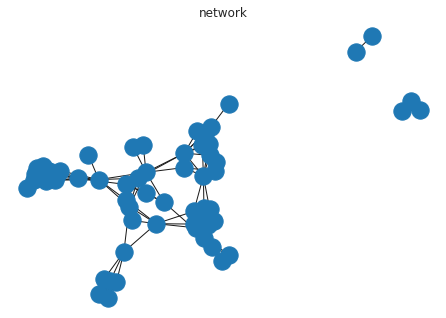

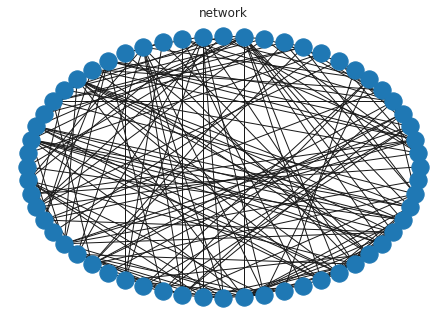

In [56]:
# default layout
plt.figure()
nx.draw(G)
plt.title('network')

# circular layout
plt.figure()
nx.draw_circular(G)
plt.title('network')

### Features of Nodes

After getting some basic measures of the entire network structure, a good next step is to find which nodes are the most important ones in your network. In network analysis, measures of the importance of nodes are referred to as centrality measures. Because there are many ways of approaching the question “Which nodes are the most important?” there are many different ways of calculating centrality. Here you’ll learn about three of the most common centrality measures: degree, betweenness centrality, and eigenvector centrality.

**Degree Distribution:** Most networks will have just a few hubs of very high degree, with the rest of similar, much lower degree

Text(0.5, 0, 'Degree')

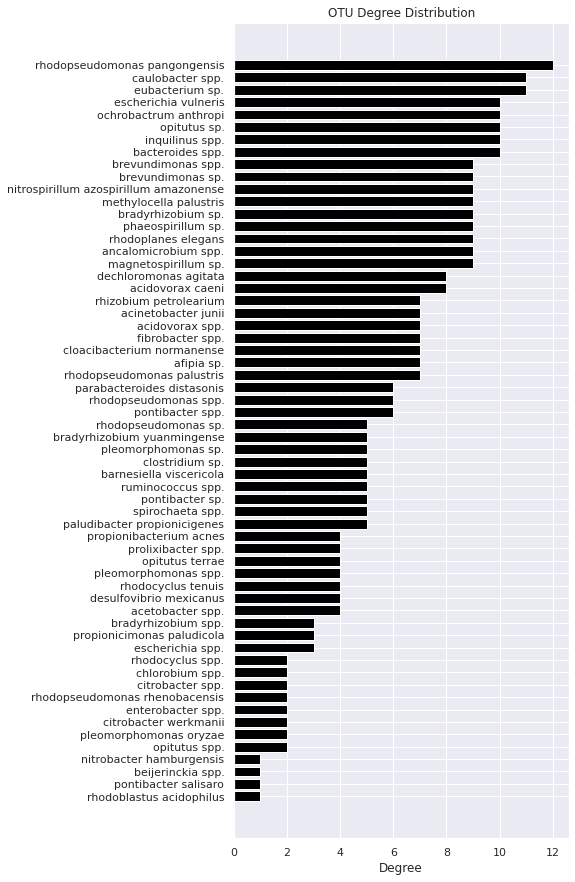

In [25]:
degree_dict = dict(G.degree(G.nodes()))
nx.set_node_attributes(G, degree_dict, 'degree')

sorted_degree = sorted(degree_dict.items(), key=itemgetter(1))
sorted_degree_OTU = [d[0] for d in sorted_degree] 
sorted_degree_degree = [d[1] for d in sorted_degree]

f, ax = plt.subplots(figsize=(6, 15))
ax.barh(sorted_degree_OTU, width=sorted_degree_degree)
ax.set_title("OTU Degree Distribution")
ax.set_xlabel("Degree")

**Eigenvector centrality:** is a kind of extension of degree—it looks at a combination of a node’s edges and the edges of that node’s neighbors. Eigenvector centrality cares if you are a hub, but it also cares how many hubs you are connected to. It’s calculated as a value from 0 to 1: the closer to one, the greater the centrality. Eigenvector centrality is useful for understanding which nodes can get information to many other nodes quickly. If you know a lot of well-connected people, you could spread a message very efficiently. If you’ve used Google, then you’re already somewhat familiar with Eigenvector centrality. Their PageRank algorithm uses an extension of this formula to decide which webpages get to the top of its search results.

Text(0.5, 0, 'Eigenvalue Centrality')

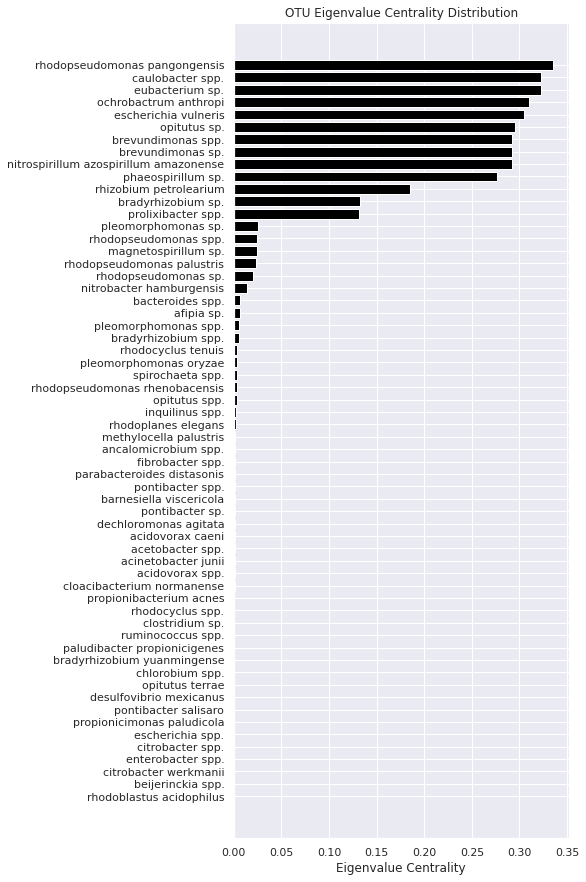

In [26]:
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

sorted_eigcen = sorted(eigenvector_dict.items(), key=itemgetter(1))
sorted_eigcen_OTU = [d[0] for d in sorted_eigcen] 
sorted_eigcen_eigcen = [d[1] for d in sorted_eigcen]

f, ax = plt.subplots(figsize=(6, 15))
ax.barh(sorted_eigcen_OTU, width=sorted_eigcen_eigcen)
ax.set_title("OTU Eigenvalue Centrality Distribution")
ax.set_xlabel("Eigenvalue Centrality")

**Betweenness centrality:** is a bit different from the other two measures in that it doesn’t care about the number of edges any one node or set of nodes has. Betweenness centrality looks at all the shortest paths that pass through a particular node (see above). To do this, it must first calculate every possible shortest path in your network, so keep in mind that betweenness centrality will take longer to calculate than other centrality measures (but it won’t be an issue in a dataset of this size). Betweenness centrality, which is also expressed on a scale of 0 to 1, is fairly good at finding nodes that connect two otherwise disparate parts of a network. If you’re the only thing connecting two clusters, every communication between those clusters has to pass through you. In contrast to a hub, this sort of node is often referred to as a broker. Betweenness centrality is not the only way of finding brokerage (and other methods are more systematic), but it’s a quick way of giving you a sense of which nodes are important not because they have lots of connections themselves but because they stand between groups, giving the network connectivity and cohesion.

Text(0.5, 0, 'Betweenness Centrality')

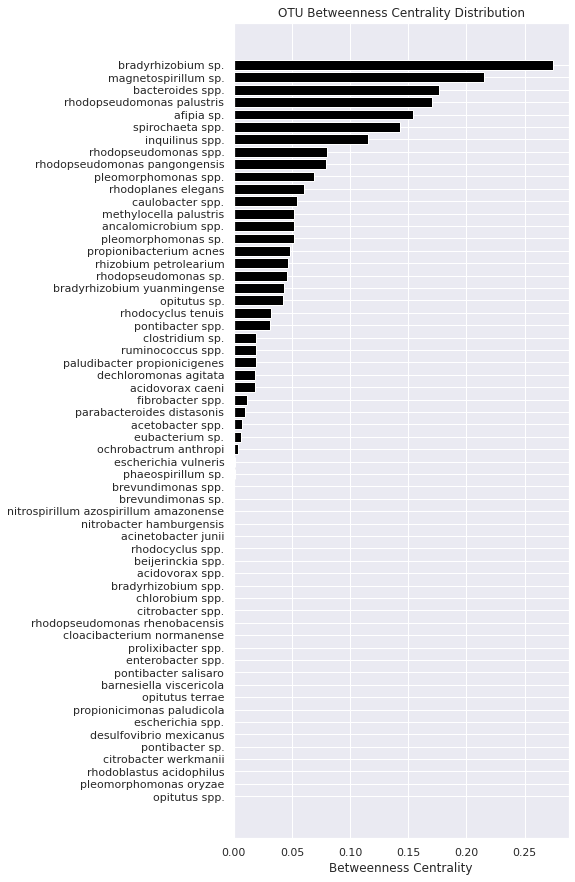

In [27]:
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
nx.set_node_attributes(G, betweenness_dict, 'betweenness')

sorted_betcen = sorted(betweenness_dict.items(), key=itemgetter(1))
sorted_betcen_OTU = [d[0] for d in sorted_betcen] 
sorted_betcen_betcen = [d[1] for d in sorted_betcen]

f, ax = plt.subplots(figsize=(6, 15))
ax.barh(sorted_betcen_OTU, width=sorted_betcen_betcen)
ax.set_title("OTU Betweenness Centrality Distribution")
ax.set_xlabel("Betweenness Centrality")

## Advanced NetworkX: Community detection with modularity

There are many ways of calculating communities, cliques, and clusters in your network, but the most popular method currently is modularity. Modularity is a measure of relative density in your network: a community (called a module or modularity class) has high density relative to other nodes within its module but low density with those outside. Modularity gives you an overall score of how fractious your network is, and that score can be used to partition the network and return the individual communities.

In [33]:
communities = community.greedy_modularity_communities(G)
M = len(communities)
communities

[frozenset({'afipia sp.',
            'bradyrhizobium sp.',
            'bradyrhizobium spp.',
            'magnetospirillum sp.',
            'nitrobacter hamburgensis',
            'opitutus spp.',
            'pleomorphomonas oryzae',
            'pleomorphomonas sp.',
            'pleomorphomonas spp.',
            'rhodopseudomonas palustris',
            'rhodopseudomonas rhenobacensis',
            'rhodopseudomonas sp.',
            'rhodopseudomonas spp.',
            'spirochaeta spp.'}),
 frozenset({'brevundimonas sp.',
            'brevundimonas spp.',
            'caulobacter spp.',
            'escherichia vulneris',
            'eubacterium sp.',
            'nitrospirillum azospirillum amazonense',
            'ochrobactrum anthropi',
            'opitutus sp.',
            'phaeospirillum sp.',
            'prolixibacter spp.',
            'rhizobium petrolearium',
            'rhodopseudomonas pangongensis'}),
 frozenset({'acetobacter spp.',
            'bacteroides s

In [29]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each OTU in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the OTU, where the value is which group they belong to.
        
# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

In [30]:
# add within-module degree attribute
within_module_degree_dict = {}
for i in G.nodes():
    neighbors = G.neighbors(i)
    module_members = [n for n in G.nodes() if G.nodes[n]['modularity'] == G.nodes[i]['modularity']]
    intersection = [v for v in neighbors if v in module_members]
    within_module_degree_dict[i] = len(intersection)
    
# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, within_module_degree_dict, 'within_module_degree')

In [32]:
# First get a list of just the nodes in that class
class0 = [n for n in G.nodes() if G.nodes[n]['modularity'] == 0]
# Then create a dictionary of the eigenvector centralities of those nodes
class0_eigenvector = {n:G.nodes[n]['eigenvector'] for n in class0}
# Then sort that dictionary and print the results
class0_sorted_by_eigenvector = sorted(class0_eigenvector.items(), key=itemgetter(1), reverse=True)
print("Modularity Class 0 Sorted by Eigenvector Centrality:")
for node in class0_sorted_by_eigenvector:
    print("Name:", node[0], "| Eigenvector Centrality:", node[1])

Modularity Class 0 Sorted by Eigenvector Centrality:
Name: bradyrhizobium sp. | Eigenvector Centrality: 0.13206418339684925
Name: pleomorphomonas sp. | Eigenvector Centrality: 0.02577603033368898
Name: rhodopseudomonas spp. | Eigenvector Centrality: 0.024600617524410968
Name: magnetospirillum sp. | Eigenvector Centrality: 0.02409608769239579
Name: rhodopseudomonas palustris | Eigenvector Centrality: 0.022875920987163383
Name: rhodopseudomonas sp. | Eigenvector Centrality: 0.02025408463310669
Name: nitrobacter hamburgensis | Eigenvector Centrality: 0.01402070093274112
Name: afipia sp. | Eigenvector Centrality: 0.006015062116628816
Name: pleomorphomonas spp. | Eigenvector Centrality: 0.005722481456889898
Name: bradyrhizobium spp. | Eigenvector Centrality: 0.005217926734340098
Name: pleomorphomonas oryzae | Eigenvector Centrality: 0.0033440890172627877
Name: spirochaeta spp. | Eigenvector Centrality: 0.003220597233852982
Name: opitutus spp. | Eigenvector Centrality: 0.0028620944384821845


## Indentification of Key Module Members

After all modules are separated, each node can be
assigned a role based on its topological properties and the role of node i is characterized by its within-module connectivity (zi) and among-module connectivity (Pi)

Peripheral nodes:     zi <= 2.5, Pi <= 0.62
Connector nodes:      zi <= 2.5, Pi > 0.62
Module hub nodes:     zi > 2.5,  Pi <= 0.62
Network hub nodes:    zi > 2.5,  Pi > 0.62

---

Sources:
* https://www.researchgate.net/post/How_should_I_interpret_the_connectivity_measures_kTotal_kWithin_kOut_kDiff_in_WGCNA
* MENAP paper

In [49]:
# add within-module connectivity attribute
within_module_connectivity_dict = {}
for i in G.nodes():
    b =  G.nodes[i]['modularity']
    k_ib = G.nodes[i]['within_module_degree']
    bs = [G.nodes[n]['within_module_degree'] for n in G.nodes if G.nodes[n]['modularity'] == b]
    k_bavg = np.mean(bs)
    k_bstd = np.std(bs)
    if (k_bstd == 0):
        within_module_connectivity_dict[i] = 0
    else:
        within_module_connectivity_dict[i] = (k_ib - k_bavg)/(k_bstd)

nx.set_node_attributes(G, within_module_connectivity_dict, 'within_module_connectivity')

In [50]:
# add among-module connectivity attribute
among_module_connectivity_dict = {}
for i in G.nodes():
    neighbors = G.neighbors(i)
    k_i = G.nodes[i]['degree']
    sum_k = 0
    for c in range(M):
        module_members = [n for n in G.nodes() if G.nodes[n]['modularity'] == c]
        intersection = [v for v in neighbors if v in module_members]
        k_ic = len(intersection)
        sum_k += (k_ic / k_i) ** 2
    among_module_connectivity_dict[i] = 1 - sum_k

nx.set_node_attributes(G, among_module_connectivity_dict, 'among_module_connectivity')

In [51]:
zt = 2.5
Pt = 0.62

peripheral_nodes_OTU = []
connector_nodes_OTU = []
module_hub_nodes_OTU = []
network_hub_nodes_OTU = []

peripheral_nodes_z = []
connector_nodes_z = []
module_hub_nodes_z = []
network_hub_nodes_z = []

peripheral_nodes_P = []
connector_nodes_P = []
module_hub_nodes_P = []
network_hub_nodes_P = []

for i in G.nodes():
    zi = G.nodes[i]['within_module_connectivity']
    Pi = G.nodes[i]['among_module_connectivity']
    print(i, "|", zi, "|", Pi)
    
    if zi <= zt and Pi <= Pt:
        peripheral_nodes_OTU.append(i)
        peripheral_nodes_z.append(zi)
        peripheral_nodes_P.append(Pi)
    elif zi <= zt and Pi > Pt:
        connector_nodes_OTU.append(i)
        connector_nodes_z.append(zi)
        connector_nodes_P.append(Pi)
    elif zi > zt and Pi <= Pt:
        module_hub_nodes_OTU.append(i)
        module_hub_nodes_z.append(zi)
        module_hub_nodes_P.append(Pi)
    else:
        network_hub_nodes_OTU.append(i)
        network_hub_nodes_z.append(zi)
        network_hub_nodes_P.append(Pi)
        
print("len peripheral nodes:", len(peripheral_nodes_OTU))
print("len connector nodes:", len(connector_nodes_OTU))
print("len module hub nodes:", len(module_hub_nodes_OTU))
print("len network hub nodes:", len(network_hub_nodes_OTU))
print("total number of nodes:", len(G.nodes))

opitutus spp. | -0.9370425713316365 | 0.0
paludibacter propionicigenes | 0 | 0.96
magnetospirillum sp. | 1.7959982617189696 | 0.3950617283950617
rhodopseudomonas palustris | 1.7959982617189696 | 0.0
acetobacter spp. | -0.3067859955389483 | 1.0
bacteroides spp. | 1.5339299776947406 | 0.96
pleomorphomonas oryzae | -0.9370425713316365 | 0.0
afipia sp. | 0.156173761888606 | 0.6734693877551021
rhodoblastus acidophilus | 0 | 1.0
spirochaeta spp. | -0.9370425713316365 | 0.84
citrobacter werkmanii | 0 | 1.0
pontibacter spp. | 0.6135719910778962 | 1.0
pontibacter sp. | 0.15339299776947393 | 1.0
ruminococcus spp. | 0 | 0.96
eubacterium sp. | 1.044185127573248 | 1.0
desulfovibrio mexicanus | 0 | 1.0
ancalomicrobium spp. | 0 | 0.9876543209876543
rhodocyclus tenuis | -0.7669649888473705 | 0.9375
escherichia spp. | 0 | 1.0
rhodoplanes elegans | 0 | 0.9876543209876543
propionicimonas paludicola | 0 | 1.0
rhodopseudomonas spp. | 0.7027819284987272 | 0.30555555555555547
pleomorphomonas spp. | -0.390434

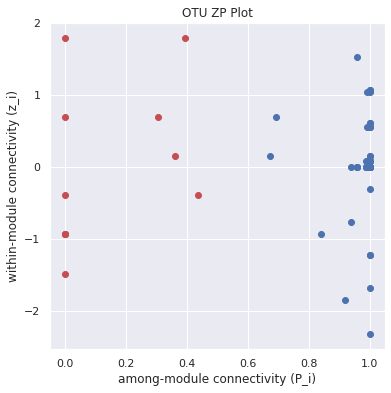

In [55]:
f, ax = plt.subplots(figsize=(6, 6))
ax.set_title("OTU ZP Plot")
ax.set_xlabel("among-module connectivity (P_i)")
ax.set_ylabel("within-module connectivity (z_i)")
ax.plot(peripheral_nodes_P, peripheral_nodes_z, 'ro')
ax.plot(connector_nodes_P, connector_nodes_z, 'bo')
ax.plot(module_hub_nodes_P, module_hub_nodes_z, 'bo')
ax.plot(network_hub_nodes_P, network_hub_nodes_z, 'bo')

## TODO: Turn This Network Analysis into separate analysis for each subsection of sample